# A simple DNN model built in Keras.

Let's start off with the Python imports that we need.

In [1]:
import os, json, math
import numpy as np
import shutil
import tensorflow as tf
print(tf.version.VERSION)

2.0.0-dev20190717


## Locating the CSV files

We will start with the CSV files that we wrote out in the [first notebook](../01_explore/taxifare.iypnb) of this sequence. Just so you don't have to run the notebook, we saved a copy in ../data

In [2]:
!ls -l ../data/*.csv

-rw-r--r-- 1 jupyter jupyter 123590 Jul 17 21:33 ../data/taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 579055 Jul 17 21:33 ../data/taxi-train.csv
-rw-r--r-- 1 jupyter jupyter 123114 Jul 17 21:33 ../data/taxi-valid.csv


## Use tf.data to read the CSV files

We wrote these cells in the [third notebook](../03_tfdata/input_pipeline.ipynb) of this sequence.

In [3]:
CSV_COLUMNS  = ['fare_amount',  'pickup_datetime',
                'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 
                'passenger_count', 'key']
LABEL_COLUMN = 'fare_amount'
DEFAULTS     = [[0.0],['na'],[0.0],[0.0],[0.0],[0.0],[0.0],['na']]

In [4]:
def features_and_labels(row_data):
    for unwanted_col in ['pickup_datetime', 'key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # features, label
             .cache())
  if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
  return dataset

In [5]:
## Build a simple Keras DNN using its Functional API
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

def build_dnn_model():
    INPUT_COLS = ['pickup_longitude', 'pickup_latitude', 
                  'dropoff_longitude', 'dropoff_latitude', 
                  'passenger_count']

    # input layer
    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in INPUT_COLS
    }
    feature_columns = {
        colname : tf.feature_column.numeric_column(colname)
           for colname in INPUT_COLS
    }
    
    # the constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires that you specify: LayerConstructor()(inputs)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation='linear', name='fare')(h2)
    model = tf.keras.models.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

model = build_dnn_model()
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dropoff_latitude (InputLayer)   [(None,)]            0                                            
__________________________________________________________________________________________________
dropoff_longitude (InputLayer)  [(None,)]            0                                            
__________________________________________________________________________________________________
passenger_count (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
pickup_latitude (InputLayer)    [(None,)]            0                                            
______________________________________________________________________________________________

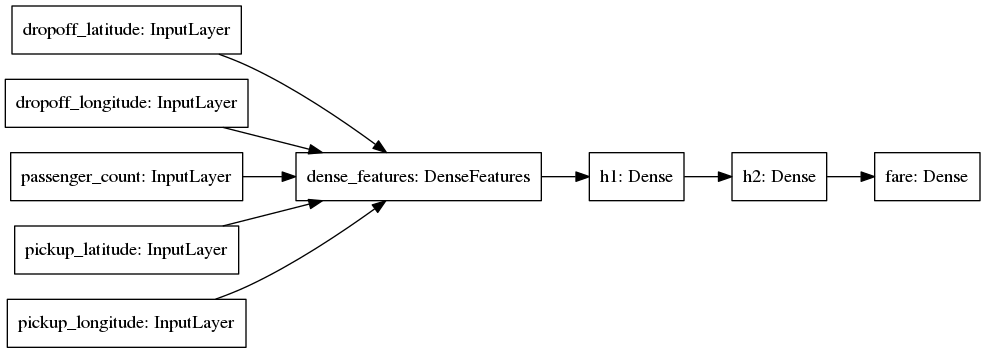

In [6]:
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

## Train model

To train the model, call model.fit().

Note that we should really use many more NUM_TRAIN_EXAMPLES (i.e. a larger dataset). We shouldn't make assumptions about the quality of the model based on training/evaluating it on a small sample of the full data.

In [7]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 5  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('../data/taxi-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('../data/taxi-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

W0717 21:36:08.766390 139980595947264 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/data/experimental/ops/readers.py:499: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
W0717 21:36:08.799426 139980595947264 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/data/experimental/ops/readers.py:212: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizati

Epoch 1/5


W0717 21:36:10.101495 139980595947264 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:460: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


312/312 [==============================] - 3s 10ms/step - loss: 94.9043 - rmse: 9.2694 - mse: 94.9043 - val_loss: 113.6341 - val_rmse: 10.6365 - val_mse: 113.6341
Epoch 2/5
312/312 [==============================] - 1s 4ms/step - loss: 98.2456 - rmse: 9.1888 - mse: 98.2456 - val_loss: 109.6463 - val_rmse: 10.4488 - val_mse: 109.6463
Epoch 3/5
312/312 [==============================] - 1s 4ms/step - loss: 99.1364 - rmse: 9.2486 - mse: 99.1365 - val_loss: 111.0516 - val_rmse: 10.5148 - val_mse: 111.0516
Epoch 4/5
312/312 [==============================] - 1s 4ms/step - loss: 96.5986 - rmse: 9.3160 - mse: 96.5985 - val_loss: 110.2645 - val_rmse: 10.4794 - val_mse: 110.2645
Epoch 5/5
312/312 [==============================] - 1s 4ms/step - loss: 97.9801 - rmse: 9.2442 - mse: 97.9801 - val_loss: 117.1142 - val_rmse: 10.7987 - val_mse: 117.1142


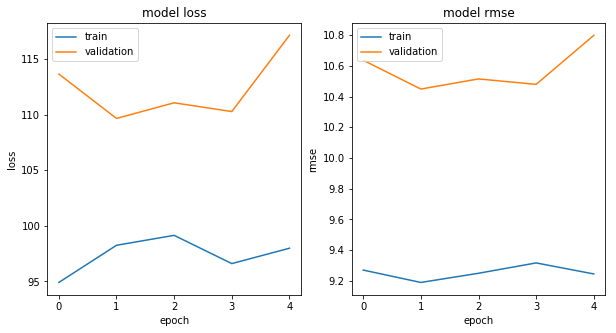

In [8]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Predict with model

This is how you'd predict with this model. 

In [9]:
model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),    
})

array([[9.243653]], dtype=float32)

Of course, this is not realistic, because we can't expect client code to have a model object in memory. We'll have to export our model to a file, and expect client code to instantiate the model from that exported file.

## Export model

Let's export the model to a TensorFlow SavedModel format. Once we have a model in this format, we have lots of ways to "serve" the model, from a web application, from JavaScript, from mobile applications, etc.

In [11]:
# This doesn't work yet.
shutil.rmtree('./export/savedmodel', ignore_errors=True)
model.save('./export/savedmodel')

# Recreate the exact same model
new_model = tf.keras.models.load_model('./export/savedmodel')

# try predicting with this model
new_model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),    
})

ValueError: in converted code:
    relative to /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python:

    keras/saving/saved_model/load.py:239 call
        return call_fn(inputs, *args, **kwargs)
    keras/saving/saved_model/utils.py:46 wrapped_call
        lambda: call_fn(inputs, training=False))
    keras/utils/tf_utils.py:58 smart_cond
        pred, true_fn=true_fn, false_fn=false_fn, name=name)
    framework/smart_cond.py:56 smart_cond
        return false_fn()
    keras/saving/saved_model/utils.py:46 <lambda>
        lambda: call_fn(inputs, training=False))
    eager/def_function.py:417 __call__
        self._initialize(args, kwds, add_initializers_to=initializer_map)
    eager/def_function.py:360 _initialize
        *args, **kwds))
    eager/function.py:1709 _get_concrete_function_internal_garbage_collected
        graph_function, _, _ = self._maybe_define_function(args, kwargs)
    eager/function.py:2013 _maybe_define_function
        graph_function = self._create_graph_function(args, kwargs)
    eager/function.py:1899 _create_graph_function
        capture_by_value=self._capture_by_value),
    framework/func_graph.py:795 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    eager/def_function.py:310 wrapped_fn
        return weak_wrapped_fn().__wrapped__(*args, **kwds)
    saved_model/function_deserialization.py:257 restored_function_body
        "\n\n".join(signature_descriptions)))

    ValueError: Could not find matching function to call loaded from the SavedModel. Got:
      Positional arguments (2 total):
        * [<tf.Tensor 'inputs:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'inputs_1:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'inputs_2:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'inputs_3:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'inputs_4:0' shape=(None, 1) dtype=float32>]
        * False
      Keyword arguments: {}
    
    Expected these arguments to match one of the following 4 option(s):
    
    Option 1:
      Positional arguments (2 total):
        * [TensorSpec(shape=(None,), dtype=tf.float32, name='dropoff_latitude'), TensorSpec(shape=(None,), dtype=tf.float32, name='dropoff_longitude'), TensorSpec(shape=(None,), dtype=tf.float32, name='passenger_count'), TensorSpec(shape=(None,), dtype=tf.float32, name='pickup_latitude'), TensorSpec(shape=(None,), dtype=tf.float32, name='pickup_longitude')]
        * True
      Keyword arguments: {}
    
    Option 2:
      Positional arguments (2 total):
        * [TensorSpec(shape=(None,), dtype=tf.float32, name='dropoff_latitude'), TensorSpec(shape=(None,), dtype=tf.float32, name='dropoff_longitude'), TensorSpec(shape=(None,), dtype=tf.float32, name='passenger_count'), TensorSpec(shape=(None,), dtype=tf.float32, name='pickup_latitude'), TensorSpec(shape=(None,), dtype=tf.float32, name='pickup_longitude')]
        * False
      Keyword arguments: {}
    
    Option 3:
      Positional arguments (2 total):
        * [TensorSpec(shape=(None,), dtype=tf.float32, name='inputs/0'), TensorSpec(shape=(None,), dtype=tf.float32, name='inputs/1'), TensorSpec(shape=(None,), dtype=tf.float32, name='inputs/2'), TensorSpec(shape=(None,), dtype=tf.float32, name='inputs/3'), TensorSpec(shape=(None,), dtype=tf.float32, name='inputs/4')]
        * True
      Keyword arguments: {}
    
    Option 4:
      Positional arguments (2 total):
        * [TensorSpec(shape=(None,), dtype=tf.float32, name='inputs/0'), TensorSpec(shape=(None,), dtype=tf.float32, name='inputs/1'), TensorSpec(shape=(None,), dtype=tf.float32, name='inputs/2'), TensorSpec(shape=(None,), dtype=tf.float32, name='inputs/3'), TensorSpec(shape=(None,), dtype=tf.float32, name='inputs/4')]
        * False
      Keyword arguments: {}


In the next notebook, we will improve this model through feature engineering.

Copyright 2019 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.